In [ ]:
!pip install --upgrade lightgbm

In [23]:
import numpy as np
import pandas as pd
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import lightgbm as lgb
import matplotlib.pyplot as plt
from lightgbm import early_stopping, log_evaluation

#======================== Generate imbalanced data ==============================
X, y = make_classification(
    n_samples=1000,
    n_features=20,
    weights=[0.9, 0.1],
    random_state=42
)



In [24]:

#============================ Introduce missing values =======================
rng = np.random.default_rng(42)
mask = rng.random(X.shape) < 0.1
X[mask] = np.nan

# =========================== Split dataset (stratified) ===============
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)



In [25]:

# ==================== Calculate scale_pos_weight for imbalance handling ===================
neg, pos = np.bincount(y_train)
scale_pos_weight = neg / pos
print(f"scale_pos_weight: {scale_pos_weight:.2f}")

# ============= Prepare datasets for LightGBM =======================
train_data = lgb.Dataset(X_train, label=y_train)
valid_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

#  ================================== LightGBM parameters ===========================
params = {
    'objective': 'binary',
    'metric': 'auc',
    'boosting_type': 'gbdt',
    'learning_rate': 0.1,
    'num_leaves': 31,
    'scale_pos_weight': scale_pos_weight,
    'verbose': -1,
    'seed': 42
}



scale_pos_weight: 8.72


Training until validation scores don't improve for 10 rounds
[10]	valid_0's auc: 0.861134
[20]	valid_0's auc: 0.865212
[30]	valid_0's auc: 0.875165
Early stopping, best iteration is:
[27]	valid_0's auc: 0.877323
Confusion Matrix:
[[259  10]
 [  9  22]]

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.96      0.96       269
           1       0.69      0.71      0.70        31

    accuracy                           0.94       300
   macro avg       0.83      0.84      0.83       300
weighted avg       0.94      0.94      0.94       300

AUC: 0.8773


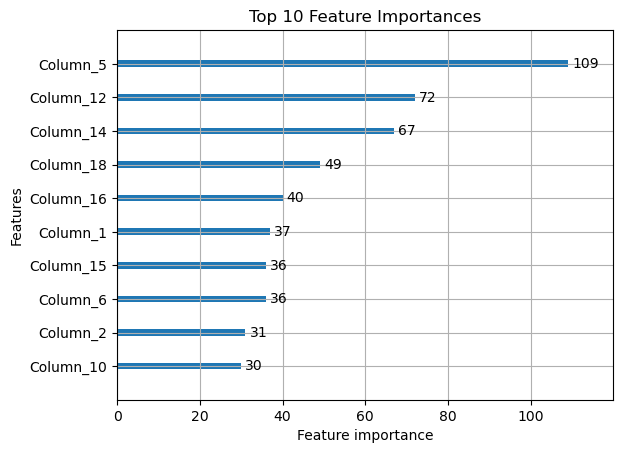

In [26]:
# ======================= Train model with callbacks for early stopping and logging ===================
model = lgb.train(
    params,
    train_data,
    valid_sets=[valid_data],
    num_boost_round=100,
    callbacks=[
        early_stopping(stopping_rounds=10),
        log_evaluation(period=10)
    ]
)

# ======================= Predict probabilities =======================
y_pred_proba = model.predict(X_test, num_iteration=model.best_iteration)

# ================== Convert probabilities to binary predictions =================
y_pred = (y_pred_proba >= 0.5).astype(int)


print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print(f"AUC: {roc_auc_score(y_test, y_pred_proba):.4f}")


lgb.plot_importance(model, max_num_features=10)
plt.title("Top 10 Feature Importances")
plt.show()